In [ ]:
"""
Created on Fri Nov 24 15:28 2023

Format SMB from Nico

Author: @claraburgard

"""

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from multimelt.constants import *
import cftime
from tqdm.notebook import tqdm
import os

In [2]:
home_path = '/bettik/burgardc/'

In [3]:
inputpath_mask = home_path+'/DATA/SUMMER_PAPER/interim/ANTARCTICA_IS_MASKS/BedMachine_4km/'
inputpath_SMB_orig = '/bettik/jourdai1/RCM_summer_paper/'
inputpath_BedMachine='/bettik/burgardc/DATA/SUMMER_PAPER/interim/'
inputpath_Chris = '/bettik/burgardc/DATA/SUMMER_PAPER/raw/TS_SMB_DATA/out/'
outputpath_smb = '/bettik/burgardc/DATA/SUMMER_PAPER/interim/SMB_EMULATED/'

In [4]:
file_isf_orig = xr.open_dataset(inputpath_mask+'BedMachinev2_4km_isf_masks_and_info_and_distance_oneFRIS.nc')
nonnan_Nisf = file_isf_orig['Nisf'].where(np.isfinite(file_isf_orig['front_bot_depth_max']), drop=True).astype(int)
file_isf_nonnan = file_isf_orig.sel(Nisf=nonnan_Nisf)
rignot_isf = file_isf_nonnan.Nisf.where(np.isfinite(file_isf_nonnan['isf_area_rignot']), drop=True)
file_isf = file_isf_nonnan.sel(Nisf=rignot_isf)

In [5]:
file_BedMachine_orig = xr.open_dataset(inputpath_BedMachine+'BedMachine_v2_aggregated4km_allvars.nc').sel(x=file_isf.x,y=file_isf.y)
isf_conc = file_BedMachine_orig['isf_conc']

grid_cell_area_file = xr.open_dataset(inputpath_BedMachine+'gridarea_ISMIP6_AIS_4000m_grid.nc').sel(x=file_isf.x,y=file_isf.y)
true_grid_cell_area = grid_cell_area_file['cell_area'].drop('lon').drop('lat')
#cell_area_weight = true_grid_cell_area/(4000 * 4000)

lon = file_isf.longitude
lat = file_isf.latitude

#xx = file_isf.x
#yy = file_isf.y
#dx = (xx[2] - xx[1]).values
#dy = (yy[2] - yy[1]).values
#grid_cell_area_const = abs(dx*dy)  
grid_cell_area_weighted = isf_conc * true_grid_cell_area

In [6]:
ref_to_compare = xr.open_dataset(inputpath_Chris + 'ERA5_SMB_historical-1980-2014.nc')
ref_to_compare['time'] = ref_to_compare['time'].dt.year

In [62]:
scenario = 'ssp245'


In [63]:
for mod in ['CNRM-CM6-1']: #'ACCESS-CM2','ACCESS-ESM1-5','CESM2-WACCM','CNRM-ESM2-1',
           #'CanESM5','GFDL-CM4','GFDL-ESM4','GISS-E2-1-H','IPSL-CM6A-LR',
           #'MRI-ESM2-0','UKESM1-0-LL'
    
    print(mod)

    if mod in ['CNRM-CM6-1','CNRM-ESM2-1']:
        ens_run = 'r1i1p1f2'
        to2300 = False
    elif mod in ['GISS-E2-1-H']:
        ens_run = 'r1i1p1f2'
        to2300 = True
    elif mod in ['ACCESS-CM2','ACCESS-ESM1-5','CESM2-WACCM','CanESM5','IPSL-CM6A-LR','MRI-ESM2-0']:
        ens_run = 'r1i1p1f1'
        to2300 = True
    elif mod in ['MPI-ESM1-2-HR','GFDL-CM4','GFDL-ESM4']:
        ens_run = 'r1i1p1f1'
        to2300 = False
    elif mod == 'UKESM1-0-LL':
        ens_run = 'r4i1p1f2'
        to2300 = True     
    elif mod == 'CESM2':
        ens_run = 'r11i1p1f1'
        to2300 = False        


    if scenario == 'historical':
        yystart = 1980 #1850
        yyend = 2014
    elif scenario == 'ssp245':
        yystart = 2015
        yyend = 2100  
    else:
        if to2300:
            yystart = 2015
            yyend = 2299
        else:
            yystart = 2015
            yyend = 2100   
    
    if mod == 'CNRM-CM6-1':
        SMB_clim = xr.open_dataset(inputpath_SMB_orig + 'MAR-'+mod+'_smb_1995-2014_clim.nc',decode_times=False)
    else:
        SMB_clim = xr.open_dataset(inputpath_SMB_orig + 'MAR-'+mod+'-'+ens_run+'_smb_1995-2014_clim.nc',decode_times=False)
    
    if scenario == 'historical':
        SMB_ano = xr.open_dataset(inputpath_SMB_orig + 'MAR-'+mod+'-'+ens_run+'_asmb_1980-2014_histo.nc',decode_times=False)
    else:
        if os.path.exists(inputpath_SMB_orig + 'MAR-'+mod+'-'+ens_run+'_asmb_'+str(yystart)+'-'+str(yyend)+'_'+scenario+'.nc'):
            SMB_ano = xr.open_mfdataset(inputpath_SMB_orig + 'MAR-'+mod+'-'+ens_run+'_asmb_'+str(yystart)+'-'+str(yyend)+'_'+scenario+'.nc',decode_times=False,chunks={'time':40})
        else:
            SMB_ano = xr.open_mfdataset(inputpath_SMB_orig + 'MAR-'+mod+'-'+ens_run+'_asmb_*_'+scenario+'.nc',decode_times=False)
        
    SMB_ano['time'] = (SMB_ano['time'] + 1900).astype(int) 
    
    sum_SMB = SMB_clim['smb'] + SMB_ano['asmb']
    
    if mod == 'CNRM-CM6-1':
        sum_SMB['x'] = grid_cell_area_weighted.x
        sum_SMB['y'] = grid_cell_area_weighted.y

    SMB_Gt_per_y = sum_SMB * grid_cell_area_weighted * yearinsec * (10**-12)

    int_SMB_list = []
    for kisf in tqdm(file_isf.Nisf):
        kisf_mask = file_isf['ISF_mask'] == kisf
        integrated_SMB = SMB_Gt_per_y.where(kisf_mask, drop=True).sum(['x','y'])
        int_SMB_list.append(integrated_SMB.assign_coords({'Nisf':kisf}))
    int_SMB_all = xr.concat(int_SMB_list, dim='Nisf')
    int_SMB_all.to_dataset(name='SMB').to_netcdf(outputpath_smb + mod +'_SMB_'+scenario+'-'+str(yystart)+'-'+str(yyend)+'.nc') 
    del int_SMB_all
    del SMB_Gt_per_y
    del sum_SMB
    del SMB_ano
    int_SMB_all = xr.open_dataset(outputpath_smb + mod +'_SMB_'+scenario+'-'+str(yystart)+'-'+str(yyend)+'.nc')

CNRM-CM6-1


  0%|          | 0/64 [00:00<?, ?it/s]

In [ ]:
int_SMB_all = xr.open_dataset(outputpath_smb + mod +'_SMB_'+scenario+'-'+str(yystart)+'-'+str(yyend)+'.nc')

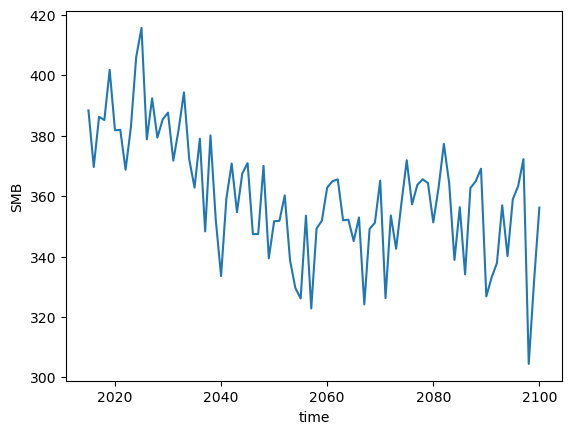

In [64]:
int_SMB_all['SMB'].sum('Nisf').plot()

In [ ]:
SMB_Gt_per_y.sum(['x','y']).mean()

In [ ]:
int_SMB_list = []
for kisf in file_isf.Nisf:
    kisf_mask = file_isf['ISF_mask'] == kisf
    integrated_SMB = SMB_Gt_per_y.where(kisf_mask, drop=True).sum(['x','y'])
    int_SMB_list.append(integrated_SMB.assign_coords({'Nisf':kisf}))
int_SMB_all = xr.concat(int_SMB_list, dim='Nisf')

In [ ]:
int_SMB_all

In [ ]:
int_SMB_all.sel(Nisf=66).plot()
ref_to_compare['SMB'].sel(Nisf=66).plot()

In [ ]:
def SMBcomponents_to_gt(SMB_array, nisf,mask,ice_frac,data_start=1980, data_end=2100):
    """ This function returns a daily time series of absolute SMB component values, expressed as gigatons. 35 000 m = MAR resolution 1e12 factor to convert kg/m² in Gt """
    
    ice=ice_frac.where(mask.values==nisf)
    reso=4.*1000.
    data = SMB_array*ice.values#*area.values
    # Make sure only wanted time frame is used
    #data = data.loc[str(data_start) + ‘-01-01’:str(data_end) + ‘-12-31’]
    # Convert to gigatons and sum up spatially over the AIS
    sum_spatial = data.sum(dim=['x', 'y']) * ((reso * reso) / (1e12))
    return sum_spatial

In [ ]:
# =============================================================================
# # OPEN the ICE MASK
# =============================================================================
mask = xr.open_dataset('BedMachinev2_4km_isf_masks_and_info_and_distance_oneFRIS.nc'
            ,decode_times=False)

isfarea=mask["isf_area_rignot"]
names=mask["isf_name"]
nisf_values=mask['Nisf'].values
mask=mask['ISF_mask']

ice=xr.open_dataset("BedMachine_v2_aggregated4km_allvars_cut.nc")
ice=ice["isf_conc"]
forcing='ACCESS1.3'
yearstart=1980
yearend=2100
ssp='rcp8.5'

In [ ]:
# =============================================================================
# # Create the future xarray dataset
# =============================================================================
# Generate nisf and time dimensions
# Generate nisf and time dimensions
#nisf_values = np.arange(0, 64, 1) # From 0 to 216
time_values = np.arange(yearstart, yearend+1, 1) # From 1980 to 2100 #will be converted later with a real time
# Generate random data for the dataset
data1 = np.random.rand(len(nisf_values), len(time_values))*0
data2 = np.random.rand(len(nisf_values), len(time_values))*0
dates = xr.cftime_range(start=str(yearstart)+"-01-01", end=str(yearend)+"-12-31", freq='AS')
                        

In [ ]:
# =============================================================================
# # OPEN the SMB file
# =============================================================================
var_list=[“SMB”,“RU”,“SF”,“RF”,“ME”]
var_list=[“SMB”]
for var in var_list:
    MAR=xr.open_dataset("in/MAR3.11-"+forcing+"_"+ssp+"-onbedmachinev2-4km_"+str(yearstart)+"-"+str(yearend)+".nc",decode_times=False)
    MAR[“time”]=dates
    # Create the xarray dataset
    dataset = xr.Dataset(
    data_vars={var: ([‘Nisf’, ‘time’], data1),
          var+‘org’: ([‘Nisf’, ‘time’], data2)},
    coords={‘Nisf’: nisf_values, ‘time’: dates})
    
    varint=MAR[var]
    varorg=MAR[var+'org']
    area=MAR["AREA"]
    newice=ice*area.values
    MAR["time"]=dates
    del(MAR)
    for nisf in range(0,len(nisf_values)):
        print (nisf,nisf_values[nisf], names.values[nisf])
        if np.isfinite(isfarea[nisf].values):
            print (nisf, "ok")
            dataset[var][nisf]=SMBcomponents_to_gt(varint, nisf_values[nisf],mask,newice).values
            dataset[var+‘org’][nisf]=SMBcomponents_to_gt(varorg, nisf_values[nisf],mask,newice).values

    # Save the xarray dataset to a NetCDF file
    historical=dataset.sel(time=slice("1980-01-01","2014-12-31"))
    if forcing != "ERA5":
        ssp585=dataset.sel(time=slice("2015-01-01",str(yearend)+"-12-31"))
        output_filename = "./out/"+forcing+'_'+var+'_'+ssp+'-2015-'+str(yearend)+'.nc'
        ssp585.to_netcdf(output_filename)
        print(“Xarray dataset saved to “+output_filename)
    
    output_filename = "./out/"+forcing+'_'+var+‘_historical-‘+str(yearstart)+‘-2014.nc’
    historical.to_netcdf(output_filename)
    print(“Xarray dataset saved to “+output_filename)